# Description
In this notebook I build, train, and evaluate a multi-label classification model for the Tanzania aerial survey data. About 95% of our aerial survey photos are empty; i.e., they contain no objects of interest.  The goal of this notebook was to use a classification model, which does inference very fast, as a preliminary filter to eliminate most of the empty tiles and thereby reduce the workload on the heavier, much slower Detectron2 bounding-box model.  

A pre-trained ResNet50 model from the `fastai` library was used as the classification model template, and the `fastai` library was used as the model environment.

The classification model was trained using the same training dataset that was used to train the Detectron2 model.  It consists of about 25,000 annotated 800px x 800px image 'tiles' (a tile is a piece of a larger image).  

## Some details about annotations
A classification model creates an annotation for a whole image, rather than a bounding box.  The training set that we created for the Detectron2 model included bounding box annotations that were stored as Pascal-VOC-style XML files, so the first task was to convert bounding-box annotations from the XML files into a format that could be used by the classification model.  

The default `fastai` dataloader expects a dataframe with filenames and a space-delimited string of labels for each image.  Once the label dataframe is built, the original XML files can be ignored.  The fastai `get_y` function then splits the 'labels' string on spaces to get individual labels.  One warning: I learned the hard way that you have to remember to check for two-word labels and convert them to single-word labels (for example, "charcoal sack" to "charcoal_sack") before `get_y` is called. That and other manipulations (for example, turning non-permitted labels into "other_animal") are done during the creation of the dataframe.  

## Doing inference on the validation set and evaluating the results
At the end of the notebook, I ran inference on the validation set (about 5,000 tiles) and explained my thinking about how to evaluate the results.  The model is doing well on the most important categories.  We have several categories where the sample sizes are too small for it to have learned much, but we aren't worried about those because they will improve as we gather additional images.  The most important result is that it seems to be missing (failing to detect) relatively few animals.  The true number is impossible to know, but it is probably <5%.  It is also producing relatively few false-positives (2.2% of this dataset).  As a caveat, I failed to always maintain an airtight seal between the training and validation sets, so it is possible that the model had already seen some of the validation images. 

## Status
- I have not yet gotten fastai's distributed inference functionality working (due to a bug or possibly an installation issue).
- I haven't turned this into a azureml script so it only works on a VM at present.

In [ ]:
import sys
from pathlib import Path
sys.path.insert(1,'/home/jp')
print(sys.path)

from lxml import etree as et
import re
from fastai.vision.all import *
from fastai.distributed import *
import xml.etree.ElementTree as etree #used in count_classes
import argparse

import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import copy 
from PIL import Image

#These are for PascalVOCWriter and PascalVOCReader
from xml.etree import ElementTree
from xml.etree.ElementTree import Element, SubElement
from lxml import etree
import codecs

from collections import Counter, OrderedDict

## Extract labels from xml files
The goal is to run through the entire training set's xml files and convert the xml categories into a csv file like this, in which labels are space-delimited:
```bash
filename  labels  
img01.jpg cat dog house
img02.jpg frog
img03.jpg frog house boat
```


In [4]:
#Define filepaths
workspace_path = Path('/cdata/tanzania/temp')
imagepath = Path('/cdata/tanzania/temp/tiled_images')
annpath = Path('/cdata/tanzania/temp/tiled_annotations')

In [46]:
#Get XML files
xml_files = [str(x) for x in annpath.iterdir() if x.suffix == '.xml'] #convert strings to Paths and get parent folder
len(xml_files), xml_files[:5]


(25187,
 ['/cdata/tanzania/temp/tiled_annotations/SL25-2013-10-09_AM_ZGF_R_0422[2][3].xml',
  '/cdata/tanzania/temp/tiled_annotations/mxj-L_20190328111422[2][3].xml',
  '/cdata/tanzania/temp/tiled_annotations/mxj-L_20190328091812[0][2].xml',
  '/cdata/tanzania/temp/tiled_annotations/mxj-L_20190328104018[1][8].xml',
  '/cdata/tanzania/temp/tiled_annotations/mxj-L_20190328100136[4][0].xml'])

In [49]:
#Define classes to be omitted or renamed
omit_labels = ['boma']
#First, wrong version
#rename_labels = {} #for first, wrong version
rename_labels = {'charcoal mound':'charcoal_mound','charcoal sack':'charcoal_sack'} #The format of this dict is oldname:newname if required.

#Set list of permitted class names.  
#Some of the rarer names are lumped into "other_animal" & the list is alphabetical
permitted_labels = [
 'buffalo',
 'building',
 'charcoal_mound',
 'charcoal_sack',
 'cow',
 'donkey',
 'eland',
 'elephant',
 'gazelle',
 'giraffe',
 'hartebeest',
 'human',
 'impala',
 'kudu',
 'oryx',
 'other_animal',
 'shoats',
 'warthog',
 'wildebeest',
 'zebra']

#Instantiate the label fixer
label_fixer = LabelFixer(permitted_labels, omit_labels, rename_labels)


In [50]:
#Check sample sizes by category
count_classes(xml_files)

[('empty_image', 10042),
 ('hartebeest', 379),
 ('Antelope', 1240),
 ('buffalo', 8699),
 ('elephant', 4354),
 ('cow', 20895),
 ('zebra', 4083),
 ('human', 3425),
 ('building', 6419),
 ('wildebeest', 1244),
 ('Ostrich', 182),
 ('boma', 1546),
 ('giraffe', 432),
 ('impala', 2189),
 ('shoats', 10530),
 ('roan', 142),
 ('eland', 629),
 ('kudu', 152),
 ('gazelle', 362),
 ('warthog', 71),
 ('hippopotamus', 380),
 ('donkey', 325),
 ('topi', 67),
 ('waterbuck', 41),
 ('charcoal sack', 141),
 ('Lion', 8),
 ('sable', 10),
 ('oryx', 41),
 ('charcoal mound', 22),
 ('Crane', 15),
 ('Stork', 4)]

In [51]:
#Convert the labels
df = convert_xml_labels_to_csv(xml_files, label_fixer)
#df

In [ ]:
#Unique label strings (which may include >1 label)
df.labels.unique()

In [55]:
#List the unique single annotations in the dataframe
l = [(re.split(' ',labelrow)) for labelrow in df.labels.unique()]
l1 = [item for sublist in l for item in sublist]
set(l1)

{'',
 'buffalo',
 'building',
 'charcoal_mound',
 'charcoal_sack',
 'cow',
 'donkey',
 'eland',
 'elephant',
 'gazelle',
 'giraffe',
 'hartebeest',
 'human',
 'impala',
 'kudu',
 'oryx',
 'other_animal',
 'shoats',
 'warthog',
 'wildebeest',
 'zebra'}

## Save the label dataframe to disk

In [56]:
df.to_csv(workspace_path/'fastai_labels.csv')

### Reload the labels (if necessary)

In [5]:
df = pd.read_csv(workspace_path/'fastai_labels.csv',keep_default_na=False)
df

,Unnamed: 0,filename,labels
0,0,SL25-2013-10-09_AM_ZGF_R_0422[2][3].jpg,hartebeest other_animal
1,1,mxj-L_20190328111422[2][3].jpg,buffalo
2,2,mxj-L_20190328091812[0][2].jpg,
3,3,mxj-L_20190328104018[1][8].jpg,
4,4,mxj-L_20190328100136[4][0].jpg,elephant
...,...,...,...
25182,25182,RR19_5EL_20180921A_RSOL_1533[2][3].jpg,shoats
25183,25183,RR17-CFA-R-2014-11-04_AM_0050[1][4].jpg,cow
25184,25184,SL25-2013-10-09_AM_ZGF_R_0417[3][0].jpg,
25185,25185,TA25-RKE-20191128A_L_4775[4][6].jpg,building


## Build the fastai Dataloader
The dataloader takes fastai's approach of resizing images to a large size on the CPU using an `item_tfm` and then resizing them down using a center crop, the latter as part of a suite of transforms done on the GPU with a `batch_tfm`.

In [6]:
#These functions define how X and Y (image and labels) are extracted from the dataframe: 
#add the path to X (filenames) and split Y (labels) on spaces.
def get_x(r): return imagepath/r['filename']
def get_y(r): return r['labels'].split(' ')

In [7]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
#                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = Resize(800),
                   batch_tfms=aug_transforms(size=500, min_scale=0.75))


In [8]:
dls = dblock.dataloaders(df,bs = 16)

## Check some images

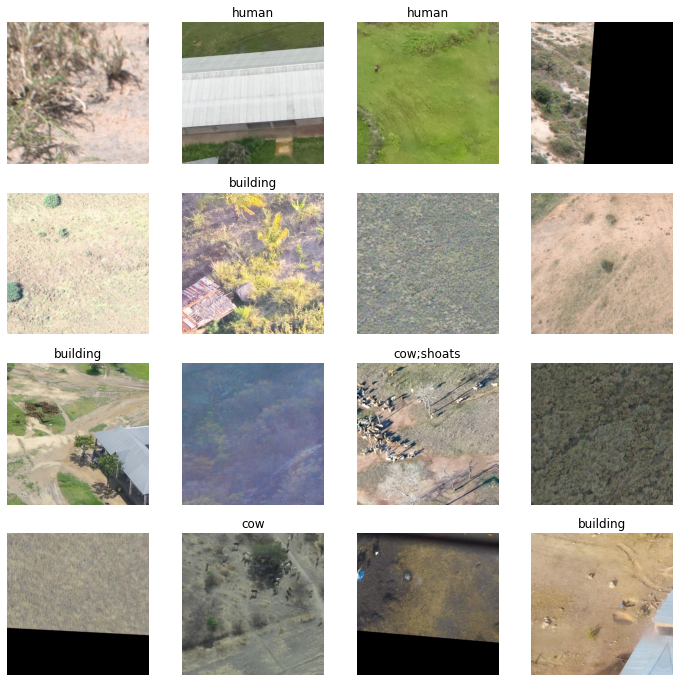

In [10]:
dls.show_batch(max_n = 16)

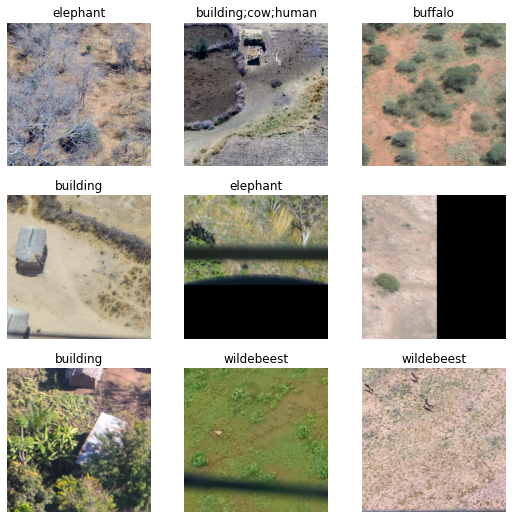

In [13]:
dls.valid.show_batch()

## Choose loss and metric functions
The default loss function in fastai is `nn.BCEWithLogitsLoss`, and the default metric is `accuracy_multi`.  We'll accept them both

## First time only: load a pre-trained fastai model
We start with a model that was trained on some other dataset.  We will use it for transfer learning.  Fastai has two ResNet50 models: `resnet50` and `xresnet50`.  I tried both and decided to choose the former.

In [11]:
#Ordinary resnet
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi,thresh=0.5))

In [8]:
#Xresnet
#learn = cnn_learner(dls, xresnet50, metrics=partial(accuracy_multi,thresh=0.5))

## Load a saved model
Note that the save path is the path of wherever this notebook is, in a subdirectory called "models", and the model is named "model.pth".  Both are fastai defaults.  
- Don't include the extension. 
- learn` is a Learner object and must be instantiated or you can't call `load` on it.  

In [ ]:
saved_model = '/path/to/saved/model'
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi,thresh=0.5))
learn = learn.load(file=saved_model)

#Loading a saved model directly from an uninstantiated Learner doesn't work
#learn = Learner.load(file=saved_model) #Fails

### Destroy the model if the GPU is hung up

In [78]:
torch.cuda.empty_cache()

## Train
Fastai training is not distributed by default.  For that, you need to create a distributed script and run it from the commandline.  To run it on an AML machine, you have the added steps that introduces (creating a new Dockerfile, creating the Docker image, uploading it, and labeling it as the environment; then creating a script to call the run script.
Methods:  
- `fit` method, for training from scratch.
- `fine_tune`, for transfer learning.  By default, `fine_tune` trains the new model head **for one epoch** and then unfreezes and trains the full model for the remaining epochs.

### First, do transfer learning with most of the layers frozen

In [65]:
#I think the output on this one was the original plain CNN model (which did better than the Xresnet!)
learn.fine_tune(epochs=3, base_lr=3e-3, freeze_epochs=4, cbs=SaveModelCallback(with_opt=True))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.120320,0.094582,0.968659,43:07
1,0.097075,0.075730,0.973595,41:25
2,0.083671,0.065246,0.977196,41:24
3,0.074840,0.056434,0.980724,41:25


Better model found at epoch 0 with valid_loss value: 0.09458241611719131.
Better model found at epoch 1 with valid_loss value: 0.07572968304157257.
Better model found at epoch 2 with valid_loss value: 0.06524591892957687.
Better model found at epoch 3 with valid_loss value: 0.056434158235788345.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.071192,0.061522,0.979190,50:28
1,0.058377,0.046793,0.983992,50:26
2,0.051406,0.041807,0.985878,50:26


Better model found at epoch 0 with valid_loss value: 0.06152200698852539.
Better model found at epoch 1 with valid_loss value: 0.046793099492788315.
Better model found at epoch 2 with valid_loss value: 0.04180704802274704.


### Now train the whole model
(Lots of epochs have been omitted for brevity)

In [31]:
learn.fit_one_cycle(8, lr_max=slice(1e-5,5e-4), cbs=SaveModelCallback(with_opt=True))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.039007,0.028674,0.990192,37:02
1,0.039081,0.028294,0.990372,37:06
2,0.038840,0.027938,0.990498,37:06
3,0.039353,0.027866,0.990706,37:07
4,0.038952,0.028181,0.990444,37:06
5,0.036562,0.027235,0.990832,37:07
6,0.035369,0.027338,0.990805,37:07
7,0.038449,0.027850,0.990598,37:05


Better model found at epoch 0 with valid_loss value: 0.028674248605966568.
Better model found at epoch 1 with valid_loss value: 0.02829446829855442.
Better model found at epoch 2 with valid_loss value: 0.02793837897479534.
Better model found at epoch 3 with valid_loss value: 0.02786567248404026.
Better model found at epoch 5 with valid_loss value: 0.027235472574830055.


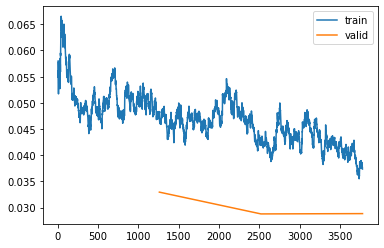

In [25]:
learn.recorder.plot_loss()

In [40]:
#WARNING: Saves the CURRENT model, not necessarily the best.  Check first.
learn.save('fastai_30Jun2021_1') 

Path('models/fastai_30Jun2021_1.pth')

## Check the learning rate

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=6.309573450380412e-07)

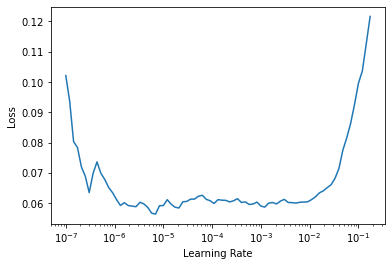

In [100]:
learn.lr_find()

### Export the model
Save all the information of our Learner object for inference: the stuff we need in the DataBunch (transforms, classes, normalization...), the model with its weights and all the callbacks our Learner was using. Everything will be in a file named `export.pkl` in the folder `learn.path`. If you deploy your model on a different machine, this is the file you'll need to copy.

In [ ]:
learn.export('saved_model_jun30')

# Change the number of classes in a `fastai` model
In this case, I was fixing a mistake, but the procedure is much the same for adding or subtracting classes from a trained model.  

**The mistake** was: The `get_y` function split a string of space-separated text labels in a multi-label classification model, and I failed to notice that two of the labels were two words ("charcoal mound" and "charcoal sack").  So when I created the dataloader, it made _three_ categories out of those two labels: "charcoal", "mound", and "sack".  I went ahead and trained it.  Now I had a trained model but the output classes were wrong.  

**The solution** is to replace the top layer and retrain.  The whole sequence was:
1. Create the dataloader with the old mistake still in it (above)
2. Load the model that was trained with the wrong classes (because it won't load if the dimensions don't match)
3. Cut and create a new model body and head as shown next
4. Remake the dataloader with the new classes (not shown)
5. Retrain


In [ ]:
learn.summary() #Shows that output dimension is 16 (batch size) x 22 (number of classes)

### Cut off the body

The `create_body` function throws an error because it expects an "architecture," so this is a simplified version of it that just grabs the existing model.

In [17]:
def create_body_from_existing(existing_model, pretrained=True, cut=None):
    "Creates a body from any model in the `timm` library."
    model = existing_model
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [18]:
body = create_body_from_existing(learn.model, pretrained=True, cut=-1)

#Check the length of the existing model
nf = num_features_model(nn.Sequential(*body.children()))
nf

2048

### Create a new head

In [19]:
#Create a new head with the desired output dimension
head = create_head(nf, 21)

### Join body with new head and initialize head

In [20]:
#Combine into a model
m2 = nn.Sequential(body, head)

#Initialize the head
apply_init(m2[1], nn.init.kaiming_normal_)

#Note that at this stage, m2 is a Sequential object and we can't use Learner.summary() on it

### Fix the dataloaders (not shown)
I just re-ran the scripts at the top of the notebook that create the label dataframe, this time using the correct classes.

### Create a learner

In [21]:
learn = Learner(dls, m2, metrics=partial(accuracy_multi,thresh=0.5))

In [ ]:
learn.summary() #Shows that there are now 21 classes

In [40]:
learn.save('model_2021_jul17')

Path('models/model_2021_jul17.pth')

### Reload model

In [22]:
learn = learn.load(file='/home/jp/jcpayne/trident_dev/dev_nbs/models/model')
#learn.load('model')

### Fine-tune training
Just retrain the top layer.  Should be relatively fast.

In [ ]:
#The kernel CRASHED after 1 epoch; had to restart
learn.fine_tune(epochs=3, base_lr=3e-3, freeze_epochs=4, cbs=SaveModelCallback(with_opt=True))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.070666,0.038670,0.988089,36:29


Better model found at epoch 0 with valid_loss value: 0.03867027908563614.


In [23]:
learn.fine_tune(epochs=2, base_lr=3e-3, freeze_epochs=3, cbs=SaveModelCallback(with_opt=True))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.053184,0.031690,0.989214,36:34
1,0.053400,0.043164,0.985952,36:30
2,0.061733,0.040317,0.986113,36:31


Better model found at epoch 0 with valid_loss value: 0.03169017657637596.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.059048,0.033629,0.988353,36:31
1,0.044473,0.028983,0.990187,36:30


Better model found at epoch 0 with valid_loss value: 0.033628515899181366.
Better model found at epoch 1 with valid_loss value: 0.028983429074287415.


In [24]:
learn.export('model_2021_jul17_028.pkl') #Note: fastai will put the file one level down (do !pwd to see where).
!pwd #/home/jp/jcpayne/trident_dev/dev_nbs

### Unfreeze and check learning rate

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

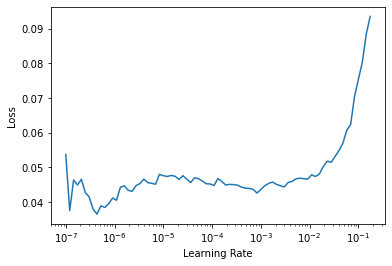

In [25]:
learn.unfreeze()
learn.lr_find()

### Train a bit more

In [27]:
learn = learn.load('model_2021_jul17_028')
#learn.unfreeze()

In [ ]:
#I changed the filename during the last iteration, so it failed when it tried to reload, but the model was saved.
#The model got to train_loss=0.034305; valid_loss=0.030346; accuracy_multi=0.989696
learn.unfreeze() #just to make sure
learn.fit_one_cycle(20, lr_max=slice(1e-5,5e-3), cbs=SaveModelCallback(with_opt=True))

## Show results

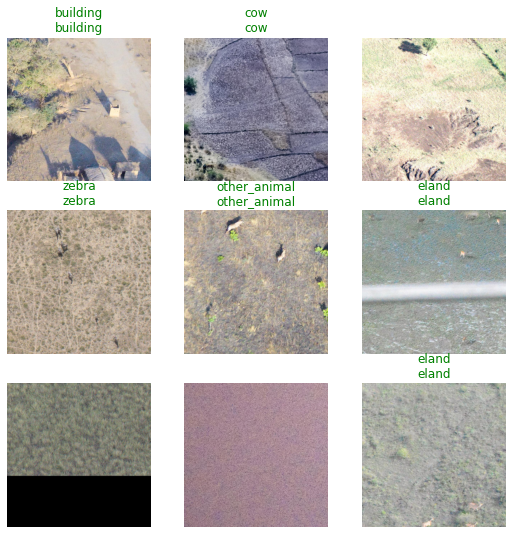

In [30]:
learn.show_results()

In [31]:
learn.export('/home/jp/jcpayne/trident_dev/dev_nbs/models/model_2021_jul18_best.pkl')

# Run inference on the validation set

## Reload the model

In [ ]:
saved_model = str(Path('.')/"models/model.pth")
learn = Learner.load(saved_model)

## Make predictions

In [34]:
#Predict a single image (as a check)
learn.predict(Path(imagepath/df.filename[0]))

((#1) ['hartebeest'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False]),
 tensor([2.1420e-02, 2.0798e-04, 7.3607e-08, 5.4243e-08, 2.5962e-06, 2.0520e-05,
         5.6855e-06, 1.7083e-03, 1.7663e-05, 6.2453e-05, 2.2652e-04, 9.6254e-01,
         9.0569e-05, 2.8225e-03, 2.5643e-06, 2.1746e-06, 2.8046e-01, 5.4093e-06,
         1.1891e-04, 2.1807e-04, 1.1777e-03]))

In [35]:
#PREDICT VALID DATASET
preds,targs = learn.get_preds(dl=dls.valid)
preds.shape

torch.Size([5037, 21])

### Convert prediction scores to binary 0/1
`get_preds` returns probability scores, but you usually need to convert those to T/F for analysis.  The threshold is arbitrary, but any `score <= threshold` will be scored as False and any `score > threshold` will be scored as True.  Setting it high would cause the model to only identify objects that it is very certain about, but you would miss out on objects it is less certain about, so the choice reflects a tradeoff between false-negative and false-positive errors. 

In [36]:
thresh = 0.5
bin_preds = torch.gt(preds, thresh).int()
bin_preds

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

## Save predictions to file
You probably find it annoying that I repeatedly save results, but it's even more annoying to have to re-run the inference. 

In [38]:
names = dls.vocab
names[0] = 'empty'
save_tensor_to_csv(targs,workspace_path/"targets.csv")
save_tensor_to_csv(preds,workspace_path/"predictions.csv")
save_tensor_to_csv(targs,workspace_path/"binary_predictions.csv")


Tensor saved as Pandas dataframe to /cdata/tanzania/temp/targets.csv
Tensor saved as Pandas dataframe to /cdata/tanzania/temp/predictions.csv
Tensor saved as Pandas dataframe to /cdata/tanzania/temp/binary_predictions.csv


In [39]:
targs.shape

torch.Size([5037, 21])

# Assess performance

Multi-label classification is not as straightforward to assess as single-label classification because we are most concerned about whether an object is _undetected_, but missing an object is confounded with the possibility that the object was _detected, but misclassified_. Once the prediction scores are converted to T/F binary predictions, our data consist of a vector of 0/1 for each category for every image.  

I made an attempt to disentangle undetected objects from misclassified objects.  It makes sense to me, but I can't guarantee that it is correct because I haven't seen it elsewhere.

In brief, the approach I took is:
1. Count the number of correct predictions and compare it to ground-truth counts for each category
2. The remainding predictions are objects that were _either undetected or misclassified_ for each category.
3. Add up the number of false-positives when the focal category prediction is wrong for each category; these serve as an upper bound estimate of the number of the focal class that might have been misclassified.  False-positives are instances where the prediction for the class was a 1 and the ground-truth was a 0.
4. Subtract the false-positives from the undetected-or-misclassified number for each category; this gives you a lower bound on the number of objects that were missed.

### Show distribution of predicted categories per true category

In [42]:
#Get the category list
dls.vocab

['empty', 'buffalo', 'building', 'charcoal_mound', 'charcoal_sack', 'cow', 'donkey', 'eland', 'elephant', 'gazelle', 'giraffe', 'hartebeest', 'human', 'impala', 'kudu', 'oryx', 'other_animal', 'shoats', 'warthog', 'wildebeest', 'zebra']

## For each ground-truth category, count the categories that were predicted
**Note 1**.  This is good measure of the number of correct predictions (which fall on the diagonal), but not as good for counting wrong predictions because, for example, if cows were always seen near goats then we'd expect to count goats on the off-diagonal when we were focusing on the cow category, and vice versa.  Therefore, we must do more complicated separation to estimate the rate of false-positives (see below). 

**Note 2**. If two categories are cross-classified in the same image, we won't pick that up.  For example, suppose that an image contains both a cow and a goat.  If the cow is classified as a goat _and_ the goat is classified as a cow, then we have no way of identifying that as a mistake.

In [43]:
pcounts = [preds_per_cat(targs,bin_preds,i) for i in range(len(targs[0]))]
pcounts = torch.stack(pcounts,dim=0)
pcounts

TensorMultiCategory([[2005,    5,   11,    0,    0,    5,    0,    0,    6,    0,    0,    0,
            2,    1,    0,    0,    4,    3,    0,    4,    7],
        [   2,  289,    0,    0,    0,    2,    0,    0,    4,    0,    0,    0,
            0,    0,    0,    0,    2,    1,    0,    0,    4],
        [   8,    0,  536,    1,    0,   13,    0,    0,    0,    0,    0,    0,
          114,    0,    0,    0,    0,   10,    0,    0,    0],
        [   0,    0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            1,    0,    0,    0,    0,    0,    0,    0,    0],
        [   6,    3,   14,    0,    0,  541,    0,    0,    1,    0,    1,    0,
           16,    2,    0,    0,    0,   33,    0,    1,    2],
        [   1,    0,    1,    0,    0,    9,    3,    0,    0,    0,    0,    0,
            2,    0,    0,    0,    

## For each ground-truth category that was missed, count the false-positives
Let's say that the model misses a zebra.  We want to estimate the probability that the model detected it but misclassified it as something else.  Therefore, we want to count false-positives in the non-focal categories (non-zebras) in images where the model missed the focal category (zebras).  The next bit of code does that for each category in turn.  The diagonal always comes out as 0, so we will combine this with the diagonal from the previous table, next.

In [63]:
#Calculate false-positives
fp = [falsepositives_per_cat(targs,bin_preds,i) for i in range(len(targs[0]))]
fp = torch.stack(fp,dim=0)
fp

TensorMultiCategory([[ 0,  4, 11,  0,  0,  5,  0,  0,  5,  0,  0,  0,  2,  1,  0,  0,  4,  3,
          0,  3,  7],
        [ 2,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  2,  0,
          0,  0,  2],
        [ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  1,
          0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 6,  1,  1,  0,  0,  0,  0,  0,  1,  0,  1,  0,  2,  2,  0,  0,  0,  5,
          0,  0,  2],
        [ 1,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,
          0,  0,  0],
        [ 1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
          0,  0,  0],
        [ 9,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,

### Combine the two

In [50]:
#Combine the diagonal (correct counts) with the false-positives off-diagonal.  Rows are ground-truth categories and columns are predictions.
ccounts = fp
for i in range(pcounts.shape[0]):
    ccounts[i,i] = pcounts[i,i]
    
c_np = ccounts.numpy()
names = dls.vocab
names[0] = 'empty'
cdf = pd.DataFrame(c_np,index=names,columns=names)
cdf

,empty,buffalo,building,charcoal_mound,charcoal_sack,cow,donkey,eland,elephant,gazelle,...,hartebeest,human,impala,kudu,oryx,other_animal,shoats,warthog,wildebeest,zebra
empty,2005,4,11,0,0,5,0,0,5,0,...,0,2,1,0,0,4,3,0,3,7
buffalo,2,289,0,0,0,0,0,0,3,0,...,0,0,0,0,0,2,0,0,0,2
building,7,0,536,0,0,0,0,0,0,0,...,0,6,0,0,0,0,1,0,0,0
charcoal_mound,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
charcoal_sack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cow,6,1,1,0,0,541,0,0,1,0,...,0,2,2,0,0,0,5,0,0,2
donkey,1,0,0,0,0,3,3,0,0,0,...,0,1,0,0,0,0,2,0,0,0
eland,1,0,0,0,0,1,0,29,0,0,...,0,0,0,0,0,2,0,0,0,0
elephant,9,3,0,0,0,0,0,0,253,0,...,0,0,0,0,0,0,0,0,0,0
gazelle,0,0,0,0,0,0,0,2,0,25,...,0,0,0,0,0,0,0,0,0,0


### Save predictions to csv

In [46]:
cdf.to_csv("prediction_counts_18jul.csv")

## Summary performance calculations
Finally, we'll see how the model is doing.

### Count images per category (ground-truth)

In [47]:
gt_counts = (torch.sum(targs,dim=0))
torch.set_printoptions(sci_mode=False)
gt_counts

TensorMultiCategory([2139.,  310.,  588.,    3.,    4.,  620.,   26.,   44.,  276.,   31.,
          42.,   29.,  313.,  129.,   20.,    3.,  168.,  318.,    5.,  105.,
         212.])

### Count predictions per category

In [48]:
pr_counts = torch.tensor([pcounts[i,i].item() for i in range(len(pcounts))])
pr_counts

tensor([2005,  289,  536,    1,    0,  541,    3,   29,  253,   25,   32,   11,
         213,   98,    6,    0,  100,  212,    0,   94,  188])

### Count number undetected or misclassified, per category

In [49]:
unseen_or_misclassified = gt_counts - pr_counts
unseen_or_misclassified

TensorMultiCategory([134.,  21.,  52.,   2.,   4.,  79.,  23.,  15.,  23.,   6.,  10.,  18.,
        100.,  31.,  14.,   3.,  68., 106.,   5.,  11.,  24.])

### Count number possibly misclassified, per category
This is the number of false-positives in the non-focal category; i.e., we count images when the focal category was wrong but there were one or more false-positives in non-focal categories in the same image.  This is probably an overestimate, since false-positives could be generated by other categories.  

For example, the model misses a buffalo but there is a false-positive in the cow column.  In this case, the model may have detected the buffalo and misclassified it as a cow; but it's also possible that the cow false-positive actually came from something else (a horse, etc.) being misclassified, and the model could have failed to detect the buffalo at all. 

In [65]:
false_pos = torch.sum(fp,dim=1)# sum the rows of fp, i.e. the possible false-positives for each category
false_pos

TensorMultiCategory([45,  9, 14,  0,  0, 21,  7,  4, 12,  2,  3,  9, 19, 11,  6,  1, 17, 28,
         4,  3,  6])

### Calculate percent correct, per category

In [52]:
pct_correct = (pr_counts/gt_counts)
pct_correct

TensorMultiCategory([0.9374, 0.9323, 0.9116, 0.3333, 0.0000, 0.8726, 0.1154, 0.6591, 0.9167,
        0.8065, 0.7619, 0.3793, 0.6805, 0.7597, 0.3000, 0.0000, 0.5952, 0.6667,
        0.0000, 0.8952, 0.8868])

### Calculate number undetected, per category
This is likely a minimum.

In [55]:
missed = gt_counts - pr_counts - false_pos
missed

TensorMultiCategory([89., 12., 38.,  2.,  4., 58., 16., 11., 11.,  4.,  7.,  9., 81., 20.,
         8.,  2., 51., 78.,  1.,  8., 18.])

### Calculate percent undetected, per category

In [56]:
pct_missed = missed/gt_counts
pct_missed

TensorMultiCategory([0.0416, 0.0387, 0.0646, 0.6667, 1.0000, 0.0935, 0.6154, 0.2500, 0.0399,
        0.1290, 0.1667, 0.3103, 0.2588, 0.1550, 0.4000, 0.6667, 0.3036, 0.2453,
        0.2000, 0.0762, 0.0849])

### Create summary table and save as dataframe

In [57]:
res = (torch.stack([gt_counts,pr_counts,undetected_or_misclassified,pct_correct,false_pos,missed,pct_missed])).t().numpy()
np.set_printoptions(suppress=True)
#res

In [58]:
names = dls.vocab
names[0] = 'empty' #Fastai automatically adds an "empty" category (meaning "no objects detected") as the first category.
summary = pd.DataFrame(res,index=names,columns=['gt_counts','pred_counts','undetected or misclassified','pct_correct','maybe misclassified','undetected','pct_unseen'])
summary.to_csv("summary_3.csv")

In [59]:
summary

,gt_counts,pred_counts,unseen or misclassified,pct_correct,maybe misclassified,unseen,pct_unseen
empty,2139.0,2005.0,134.0,0.937354,45.0,89.0,0.041608
buffalo,310.0,289.0,21.0,0.932258,9.0,12.0,0.038710
building,588.0,536.0,52.0,0.911565,14.0,38.0,0.064626
charcoal_mound,3.0,1.0,2.0,0.333333,0.0,2.0,0.666667
charcoal_sack,4.0,0.0,4.0,0.000000,0.0,4.0,1.000000
cow,620.0,541.0,79.0,0.872581,21.0,58.0,0.093548
donkey,26.0,3.0,23.0,0.115385,7.0,16.0,0.615385
eland,44.0,29.0,15.0,0.659091,4.0,11.0,0.250000
elephant,276.0,253.0,23.0,0.916667,12.0,11.0,0.039855
gazelle,31.0,25.0,6.0,0.806452,2.0,4.0,0.129032


### Count true empties misclassified

In [60]:
#The number of true empties that were misclassified as non-empty (i.e., 1 or more false-positives)
sum(pcounts[0,1:])

tensor(48)

In [61]:
48/2130 #2.2% of the empties are false-positives

0.022535211267605635

## Count non-empties that were classified as empty
**This is the most important statistic of all** (the One Ring to Rule Them All)

In [62]:
#The number of non-empties that were classified as empty
not_empty = sum(pcounts[1:,0])
not_empty_pct = not_empty/sum(targs[:,0]) * 100
nepct = "%.2g" % not_empty_pct
msg = f"Number of non-empty images classified as empty: {not_empty}({nepct}%)"
print(msg)

Number of non-empty images classified as empty: 56(2.6%)
